## Initialization

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F
from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm

#from ENV import KYenv
from ENV import KYenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

### Initiliaze environments

In [4]:
test_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])

test_env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = test_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )

TypeError: __init__() got an unexpected keyword argument 'border'

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
envs = []


for s in tqdm(range(100)):
    set_seed(s)
#     t_aps = torch.rand(k)
    t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
    env = Env(boarder=100,
          apNum=4,ueNum=24,random_seed=s
          )
    envs.append(env)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
envs[0].struct_obv().shape[0]

24

### Initialize models

In [6]:
inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
controller.save('models/' + inter_file_name)
controller.cuda()
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64, est_type = "discounted")
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0

In [7]:
inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
avg_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
avg_controller.save('models/' + inter_file_name)
avg_controller.cuda()
avg_learner = QLearner(avg_controller,device="cuda",batch_size=32,num_feats=64, est_type = "average")
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0

### Training

  0%|          | 0/350 [00:00<?, ?it/s]

Env:1|Iteration:0|loss:201.26|reward:15.04|action:tensor([2, 0, 0, 2])|rscore:0.6855671318613987
Env:1|Iteration:1|loss:284.37|reward:14.96|action:tensor([3, 3, 1, 3])|rscore:0.6400587373299622
Env:1|Iteration:2|loss:298.09|reward:14.83|action:tensor([0, 0, 3, 0])|rscore:0.7648334505114012
Env:1|Iteration:3|loss:289.89|reward:13.94|action:tensor([2, 0, 0, 0])|rscore:0.574031890157617
Env:1|Iteration:4|loss:304.96|reward:14.20|action:tensor([2, 0, 0, 0])|rscore:0.5781172355753437
Env:1|Iteration:5|loss:320.13|reward:14.28|action:tensor([2, 0, 0, 0])|rscore:0.6139079663896339
Env:1|Iteration:6|loss:327.69|reward:15.37|action:tensor([2, 0, 0, 0])|rscore:0.7716219289742495
Env:1|Iteration:7|loss:320.32|reward:14.93|action:tensor([1, 3, 0, 3])|rscore:0.7638921092052434
Env:1|Iteration:8|loss:326.21|reward:14.72|action:tensor([1, 3, 0, 3])|rscore:0.5584393980590394
Env:1|Iteration:9|loss:335.80|reward:15.70|action:tensor([1, 3, 0, 3])|rscore:0.875655447312959
Env:1|Iteration:10|loss:320.73|r

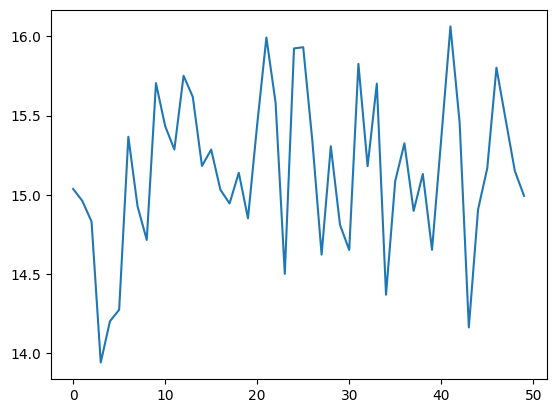

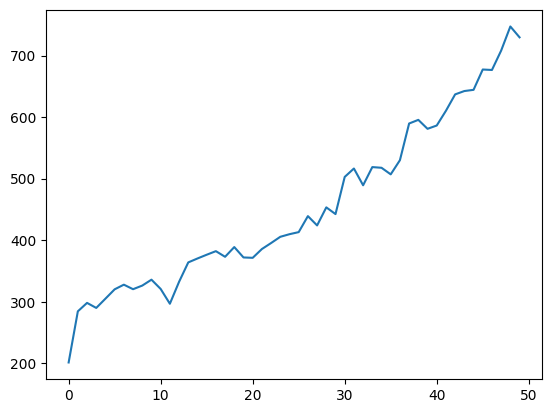

Env:1|Iteration:50|loss:755.18|reward:16.15|action:tensor([1, 3, 0, 3])|rscore:0.8196442728048111
Env:1|Iteration:51|loss:794.92|reward:15.51|action:tensor([1, 3, 0, 3])|rscore:0.802303441256736
Env:1|Iteration:52|loss:812.58|reward:14.03|action:tensor([1, 3, 0, 3])|rscore:0.5886209751535693
Env:1|Iteration:53|loss:804.67|reward:15.42|action:tensor([1, 3, 0, 3])|rscore:0.724247286663714
Current best 23.63 at iteration 53! Saving.... 
Env:1|Iteration:54|loss:793.42|reward:14.73|action:tensor([1, 3, 0, 3])|rscore:0.6786141628068116
Env:1|Iteration:55|loss:820.46|reward:14.85|action:tensor([1, 3, 0, 3])|rscore:0.640855602715751
Env:1|Iteration:56|loss:844.25|reward:14.56|action:tensor([1, 3, 0, 3])|rscore:0.7015621018559348
Env:1|Iteration:57|loss:874.66|reward:15.27|action:tensor([1, 3, 0, 3])|rscore:0.7057590584681155
Env:1|Iteration:58|loss:878.49|reward:15.25|action:tensor([1, 3, 0, 3])|rscore:0.680155003136831
Env:1|Iteration:59|loss:925.68|reward:14.33|action:tensor([1, 3, 0, 3])|rs

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7fa0bf5404a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/tqdm/notebook.py", line 264, in __iter__
    self.disp(bar_style='danger')
  File "/usr/local/lib/python3.9/site-packages/tqdm/notebook.py", line 164, in display
    msg = self.format_meter(**d)
  File "/usr/local/lib/python3.9/site-packages/tqdm/std.py", line 437, in format_meter
    elapsed_str = tqdm.format_interval(elapsed)
  File "/usr/local/lib/python3.9/site-packages/tqdm/std.py", line 308, in format_interval
    return '{0:02d}:{1:02d}'.format(m, s)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [13]:
import pdb
# Defining hyperparams
niterations = 350
max_inner_iter = 1000
max_test_iter = 1000
outerstepsize = 1
# random_seeds = [0,5,3,6,9,14,16,25,22,29]
# random_seeds = [35, 40, 45]
random_seeds = [1,2,3,4,5]
k = 0
epsilon = 0.9
results_dict = {"loss": None,
               "reward": None}
# pbar = tqdm(range(niterations))
# best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
for k in random_seeds:
    inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
    cuda_flag = True

    # initialize learner
    controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    controller.save('models/' + inter_file_name)
    controller.cuda()
    learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64, est_type = "discounted")
    if cuda_flag:
        learner.cuda()

    # initialize test learner
    test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    test_controller.load('models/' + inter_file_name)
    test_controller.cuda()
    test_controller.init_hidden(batch_size=1)
    lr = 5e-4
    learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    best = 0
    r_history, loss_history = [], []
    for iteration in pbar:
        env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            learner.set_sgd(lr)
        losses = []
    
        for inner_iter in range(max_inner_iter):
            total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
#             obs = [5
# #         breakpoint()
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
#         breakpoint()
            cur_obs = obs.reshape(1,24).cuda()
            controller.init_hidden(1)
            action,q = controller.get_action(cur_obs, 1 * (1-iteration/niterations))
            if random.random() < epsilon:
                action = np.random.randint(255)
#             pdb.set_trace()
            act = decode_act(action,4,4)
            s_t1,r = env.step(act)
            s_t1 = torch.flatten(s_t1)
            controller.init_hidden(512)
            loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
            if loss is not None:
                losses.append(loss.item())
        
        learner._update_targets()
    # Save the results
        if losses != []:
            loss_history.append(np.mean(losses))
    # save and update the test controller
        controller.save('models/' + inter_file_name)
        test_controller.load('models/' + inter_file_name)
        env.reset()
        reward = 0
        epsilon -= 1/(niterations + 1)
        for test_iter in range(max_test_iter):
#             obs = []
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
# #         breakpoint()
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
            action,_ = test_controller.get_action(
                torch.reshape(obs,(1,24)).cuda(), 0.0)
#             action = 0
            act = decode_act(action,4,4)
            s_t1,r = env.step(act)
            reward += r
        r_history.append(reward.item()/max_test_iter)
        pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{np.mean(r_history):.2f}|action:{act}")
        print(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item()/max_test_iter:.2f}|action:{act}|rscore:{env.get_Rsum()/24 + env.get_R5per()*3}")
        if r.item() > best and iteration > 10:
            best = r.item()
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/drqn_best_centralized_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_centralized_results_dist.pkl", "wb") as file:
                pickle.dump(results_dict, file)
        

In [ ]:
import pdb
# Defining hyperparams
niterations = 350
max_inner_iter = 1000
max_test_iter = 1000
outerstepsize = 1
# random_seeds = [0,5,3,6,9,14,16,25,22,29]
# random_seeds = [35, 40, 45]
random_seeds = [1,2,3,4,5]
k = 0
epsilon = 0.9
results_dict = {"loss": None,
               "reward": None}
# pbar = tqdm(range(niterations))
# best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
for k in random_seeds:
    lr = 5e-4
    inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
    cuda_flag = True

    # initialize learner
    avg_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    avg_controller.save('models/' + inter_file_name)
    avg_controller.cuda()
    avg_learner = QLearner(avg_controller,device="cuda",batch_size=32,num_feats=64, est_type = "average")
    if cuda_flag:
        avg_learner.cuda()

    # initialize test learner
    test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    test_controller.load('models/' + inter_file_name)
    test_controller.cuda()
    test_controller.init_hidden(batch_size=1)

    avg_learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    best = 0
    r_history, loss_history = [], []
    for iteration in pbar:
        env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            learner.set_sgd(lr)
        losses = []
    
        for inner_iter in range(max_inner_iter):
            total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
#             obs = [5
# #         breakpoint()
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
#         breakpoint()
            cur_obs = obs.reshape(1,24).cuda()
            avg_controller.init_hidden(1)
            action,q = avg_controller.get_action(cur_obs, 1 * (1-iteration/niterations))
            if random.random() < epsilon:
                action = np.random.randint(255)
#             pdb.set_trace()
            act = decode_act(action,4,4)
            s_t1,r = env.step(act)
            s_t1 = torch.flatten(s_t1)
            avg_controller.init_hidden(512)
            loss, grad = avg_learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
            if loss is not None:
                losses.append(loss.item())
        
        learner._update_targets()
    # Save the results
        if losses != []:
            loss_history.append(np.mean(losses))
    # save and update the test controller
        avg_controller.save('models/' + inter_file_name)
        test_controller.load('models/' + inter_file_name)
        env.reset()
        reward = 0
        epsilon -= 1/(niterations + 1)
        for test_iter in range(max_test_iter):
#             obs = []
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
# #         breakpoint()
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
            action,_ = test_controller.get_action(
                torch.reshape(obs,(1,24)).cuda(), 0.0)
#             action = 0
            act = decode_act(action,4,4)
            s_t1,r = env.step(act)
            reward += r
        r_history.append(reward.item()/max_test_iter)
        pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{np.mean(r_history):.2f}|action:{act}")
        print(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item()/max_test_iter:.2f}|action:{act}|rscore:{env.get_Rsum()/24 + env.get_R5per()*3}")
        if r.item() > best and iteration > 10:
            best = r.item()
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/drqn_best_centralized_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_centralized_results_avg.pkl", "wb") as file:
                pickle.dump(results_dict, file)

  0%|          | 0/350 [00:00<?, ?it/s]

Env:1|Iteration:0|loss:183.32|reward:14.90|action:tensor([0, 0, 2, 2])|rscore:0.6814415236677429
Env:1|Iteration:1|loss:208.88|reward:14.92|action:tensor([3, 3, 1, 3])|rscore:0.6384047740265676
Env:1|Iteration:2|loss:167.70|reward:14.82|action:tensor([0, 0, 3, 0])|rscore:0.7668499231887713
Env:1|Iteration:3|loss:126.53|reward:13.98|action:tensor([2, 0, 0, 0])|rscore:0.57960915180443
Env:1|Iteration:4|loss:107.03|reward:14.20|action:tensor([2, 0, 0, 0])|rscore:0.5781172355753437
Env:1|Iteration:5|loss:91.44|reward:14.28|action:tensor([2, 0, 0, 0])|rscore:0.6139079663896339
Env:1|Iteration:6|loss:77.80|reward:15.37|action:tensor([2, 0, 0, 0])|rscore:0.7716219289742495
Env:1|Iteration:7|loss:58.18|reward:14.58|action:tensor([2, 0, 0, 0])|rscore:0.7713890430732676
Env:1|Iteration:8|loss:53.87|reward:14.73|action:tensor([1, 1, 3, 3])|rscore:0.5137420383730609
Env:1|Iteration:9|loss:45.81|reward:15.25|action:tensor([1, 1, 3, 3])|rscore:0.8782576243566189
Env:1|Iteration:10|loss:37.56|reward:

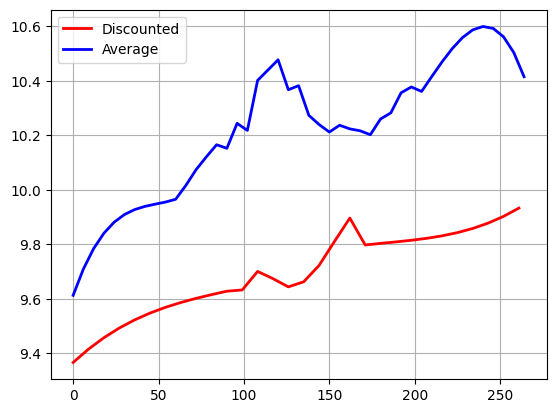

In [44]:
from scipy.signal import savgol_filter
with open("./results/env_10_centralized_results_avg.pkl", "rb") as file:
            avg_result = pickle.load(file)
with open("./results/env_10_centralized_results_dist.pkl", "rb") as file:
            dist_result = pickle.load(file)
avg_history = avg_result["reward"]
dist_history = dist_result["reward"]
plt.plot(list(range(0,270,9)),savgol_filter(dist_history[20:50], 21, 3) , lw = 2, color = "red", label = "Discounted")
plt.plot(list(range(0,270,6)),savgol_filter(avg_history[0:45], 21, 3) , lw = 2, color = "blue", label = "Average")

plt.grid()
plt.legend()

In [ ]:
dist_

### Draw results

In [16]:
with open("./results/env_0_results.pkl", "rb") as file:
            result = pickle.load(file)

In [3]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import os 
import sys
import matplotlib.pyplot as plt

In [8]:
from glob import glob
dirs = glob("./results/*_results*_avg.pkl")
discounted_dirs = glob("./results/*_results*_dist.pkl")

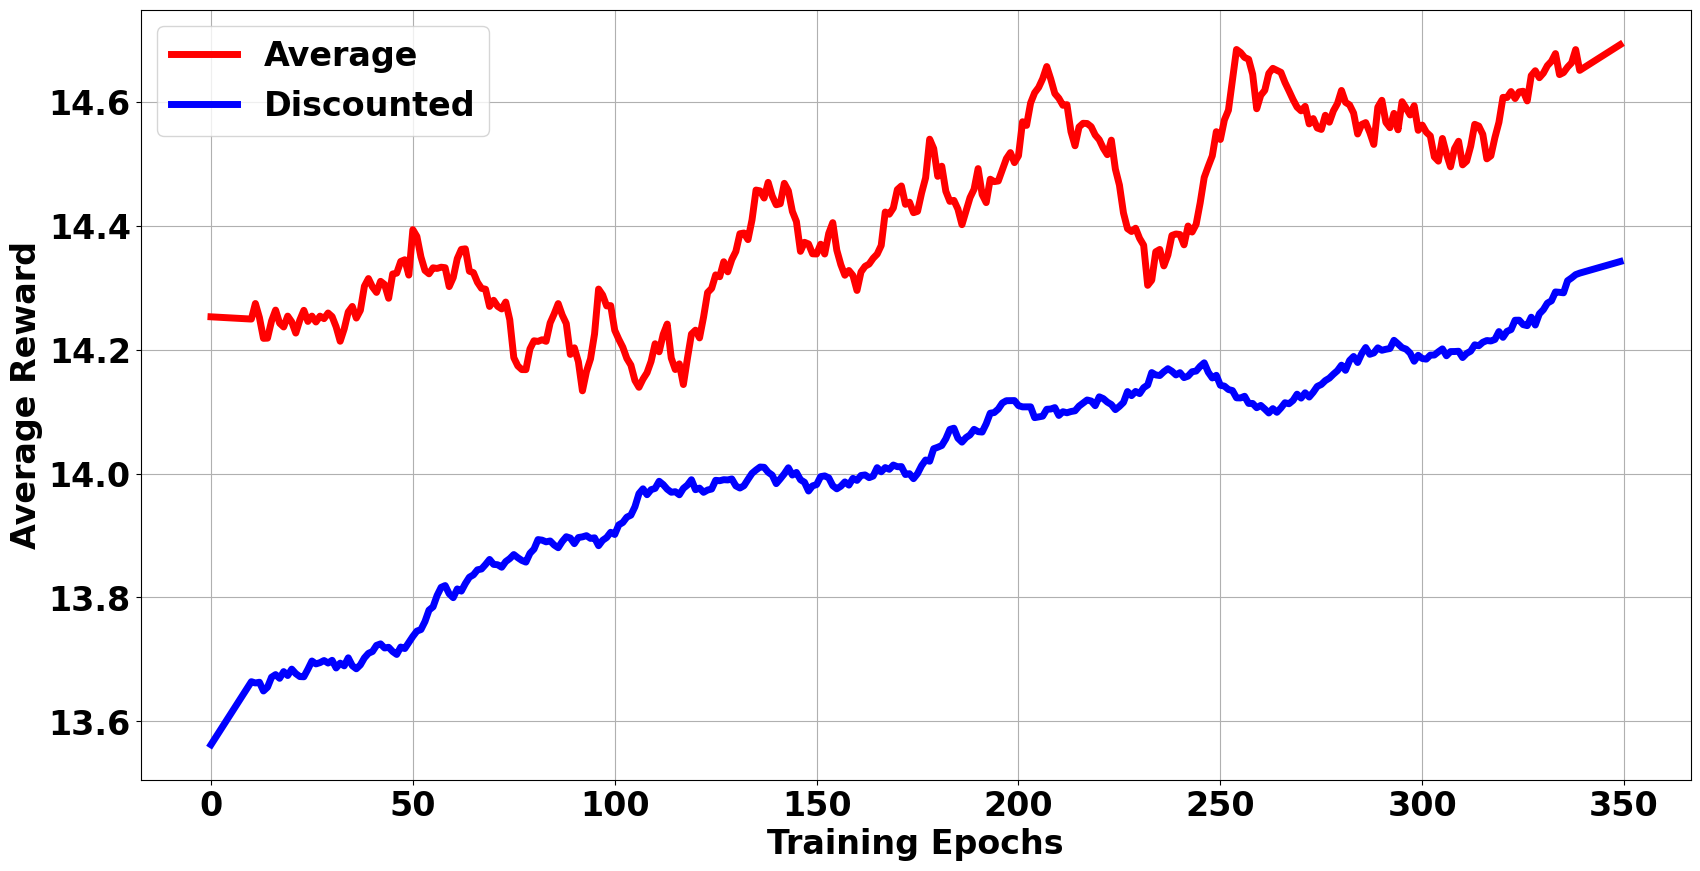

In [35]:
import json
import matplotlib
import pdb
from scipy.signal import savgol_filter

figure_map= {
    "MARL":["b", "-"],
    "Centralized_RL":["r","-."],
    "Heuristic_baseline":["g",":"]
    
}

font = {'weight' : 'bold',
        'size'   : 24}

results = {}

for i,d in enumerate(dirs):
#     breakpoint()
    d = dirs[i]
    label = dirs[i].split("_")[-1]
    
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if len(r) != 350:
            continue
        if label not in results:
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            results[label] += np.array(r)
        else:
            r = np.array(r)
            results[label] += np.array(r)

plt.figure(figsize = (20,10))
# if label == "centralized":
#     label_n = "Centralized_RL"
plt.plot(savgol_filter(results["avg.pkl"], 21, 1)/(len(dirs)-1),c = "red",lw=5 ,ls="-", label = "Average")
plt.plot(savgol_filter(results["dist.pkl"], 21, 1),c = "blue",lw=5 ,ls="-", label = "Discounted")
plt.xlabel("Training Epochs", fontsize=24, weight="bold")
plt.ylabel("Average Reward", fontsize=24, weight="bold")
matplotlib.rc('font', **font)
plt.grid()
plt.legend()



In [31]:
discounted_dirs

{'avg.pkl': array([72.76444824, 73.45820117, 71.87247168, 70.49756445, 70.63403418,
        68.6964707 , 71.83890918, 71.02915625, 70.07533887, 72.09348926,
        70.45494629, 70.87125195, 71.51434082, 70.95227734, 69.43533594,
        72.12023145, 71.690125  , 72.37347949, 65.45757422, 73.61198926,
        74.77852148, 75.40505762, 71.06977051, 68.35014063, 70.52982617,
        73.54578809, 70.54400391, 69.61815625, 70.38443164, 71.92041602,
        71.1116543 , 68.55984863, 73.0707627 , 73.1720293 , 69.0735166 ,
        70.3371377 , 71.11877539, 72.6862002 , 71.94347461, 66.41691504,
        73.00295215, 73.03091211, 72.96919141, 73.1762041 , 71.21913867,
        71.45881445, 71.57537305, 71.85431348, 73.71394336, 71.67754395,
        70.49353027, 70.19437695, 70.43468359, 72.5342168 , 70.83730078,
        73.19099414, 70.47850293, 73.10580078, 72.96875781, 69.34169629,
        74.12401172, 71.8471748 , 69.5685166 , 70.6730332 , 72.60814746,
        72.23181836, 71.35037012, 71.789